# Repeating ML selected mixed halide compositions


# XRD Results

In [20]:
#   Import Data
import glob
import pandas as pd
import plotly.express as px
import numpy as np
import math
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.sparse import linalg
from numpy.linalg import norm
import matplotlib.pyplot as plt

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

def trim_data(x,data,limit1,limit2):
    set1 = find_nearest(x,limit1)
    set2 = find_nearest(x,limit2)
    return x[set1:set2], data[set1:set2]

def twotheta_to_q(angle, lam = 1.54060):
  angle_rad = angle/2*np.pi/180
  return 4*np.pi*np.sin(angle_rad)/lam

def gaussian(x, a, b, c): 
    #generic gaussian curve, for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a*np.exp(-(x - b)**2/(2*c**2))

def normal_gaussian(x, a, b): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the peak position and 
    #b is the FWHM
    return 2/b*sqrt(ln(2)/math.pi)*np.exp(-4*ln(2)/b**2*(x - a)**2)

def two_gaussians(x, a1, b1, c1, a2, b2, c2):
        return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2))

def multi_gaussian(x, guesses):
    #NOTE This function does not work with curve fitting yet TBD
    # x is 1D array of 2-theta or q values for our fitting
    # trips is an array of fits i.e. [[200, 1, .01], [150, 1.05. .02]]
    peaks = [gaussian(x, fit[0], fit[1], fit[2]) for fit in guesses]
    return np.sum(peaks, axis=0)

# Define three peak fitting
def three_gaussians(x, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2)+ #this would be your initial peak center in Q
            gaussian(x, a3, b3, c3))
            
def normal_gaussian(x, a, b, c): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the instensity 
    #b is the peak position and 
    #c is the variance (FWHM = sqrt(2ln2)*c)
    return a/(c*np.sqrt(2*math.pi))*np.exp(-(x - b)**2/(2*c**2))

def lorentz(x, a, b, c):
    #generic lorentzian curve, for xrd analysis
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a/np.pi*((c/2)/((x-b)**2+(c/2)**2))

def pvoigt(x, e, a, b, c):
    #pseudovoigt curve common in xrd analysis
    #linear combination of lorentzian and gaussian curves
    #e is the fraction that is lorentzian
    c_g = c/(2*np.sqrt(2*np.log(2)))
    return e*lorentz(x, a, b, c) + (1-e)*normal_gaussian(x,a,b,c_g)

def double_pvoigt(x, e, a1, b1, c1, a2, b2, c2):
    #pseudovoigt curve common in xrd analysis
    #linear combination of lorentzian and gaussian curves
    #e is the fraction that is lorentzian
    c_g1 = c1/(2*np.sqrt(2*np.log(2)))
    c_g2 = c2/(2*np.sqrt(2*np.log(2)))
    return e*lorentz(x, a1, b1, c1) + (1-e)*normal_gaussian(x,a1,b1,c_g1) + e*lorentz(x, a2, b2, c2) + (1-e)*normal_gaussian(x,a2,b2,c_g2)

def baseline_als(y, lam, p, niter=10):
  #https://stackoverflow.com/questions/29156532/python-baseline-correction-library
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

def baseline_arPLS(y, ratio=1e-6, lam=100, niter=10, full_output=False):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252

    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)

    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = norm(w_new - w) / norm(w)

        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        info = {'num_iter': count, 'stop_criterion': crit}
        return z, d, info
    else:
        return z

def xrd_basic(data):
  chem = pd.read_csv(data,header = None, names=None)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_arPLS(chem_np[:,1])
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),13,2)

  chem_out = pd.DataFrame(chem_np)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_basic1(data):
  chem = pd.read_csv(data,header = None, names=None)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**4, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),13,2)

  chem_out = pd.DataFrame(chem_np)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_basic_q(data):
  chem = pd.read_csv(data,header = None, names=None)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**4, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),13,2)
  chem_np[:,0] = twotheta_to_q(chem_np[:,0])
  chem_out = pd.DataFrame(chem_np)
  chem_out.columns = ["Q","Intensity"]
  return chem_out

def xrd_focus(data,limit1,limit2):
  chem = pd.read_fwf(data, colspecs='infer', skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_arPLS(chem_np[:,1])
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),15,2)
  theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
  
  chem_cut = np.column_stack((theta_cut,chem_cut))
  chem_out = pd.DataFrame(chem_cut)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_focus1(data,limit1,limit2):
  chem = pd.read_csv(data, delim_whitespace=True, skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**8, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),15,2)
  theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
  chem_cut = np.column_stack((theta_cut,chem_cut))
  chem_out = pd.DataFrame(chem_cut)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_focus_q(data,limit1,limit2):
  chem = pd.read_csv(data, delim_whitespace=True, skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**8, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),13,2)
  theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
  q_cut = twotheta_to_q(theta_cut)
  chem_cut = np.column_stack((q_cut,chem_cut))
  chem_out = pd.DataFrame(chem_cut)
  chem_out.columns = ["Q","Intensity"]
  return chem_out

def cubic_lattice(twotheta, miller):
  return 1.5406*math.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)/(2*math.sin(twotheta*math.pi/180/2))

def xrd_fit(dataset,limit1,limit2):
  #   Do a curve fit
  chem_np = np.array(dataset)
  peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
  p0 = [0.2, np.max(chem_np[:,0]), peak, .1] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
  upper_limit = [1, 3000, limit2, 2]
  lower_limit = [0, 0, limit1, 0]
  popt, pcov = curve_fit(pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
  chem_out = np.column_stack((chem_np,pvoigt(chem_np[:,0],*popt),chem_np[:,1]/np.max(chem_np[:,1])))
  chem_fit = pd.DataFrame(chem_out)
  chem_fit.columns = ["2Theta","Intensity","Fit", "Norm_Inten"]
  return popt, pcov, chem_fit

path = r'/Users/rbelisle/Desktop/ML Project/220810_MLProject/'
all_files = sorted(glob.glob(path+"/*.plt"))
limit1 = 10
limit2 =45
print(all_files)

['/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_001.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_002.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_003.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_004.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_005.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_006.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_007.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_008.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_009.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_010.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_011.plt', '/Users/rbelisle/Desktop/ML Project/220810_MLProject/081022_MLProject_012.plt', '/Users/rbelisle/Desktop/ML Project/220

In [2]:
all_files[0].split('_')[-1].split('.')[0]

'001'

# Import Chemistry

In [17]:
chems = pd.read_csv('/Users/rbelisle/Desktop/ML Project/220810_MLProject/ML_compositions.csv',skipfooter=5)
print(chems)


      Cl     I    Br  Predicted Lattice      [100]      [110]      [200]  \
0   0.10  0.79  0.11           6.189745  14.297732  20.273216  28.824330   
1   0.66  0.09  0.25           5.796186  15.274148  21.665855  30.828453   
2   0.83  0.07  0.10           5.749627  15.398579  21.843444  31.084371   
3   0.17  0.59  0.24           6.097984  14.514030  20.581580  29.267679   
4   0.32  0.42  0.26           5.999566  14.753436  20.922977  29.758790   
5   0.49  0.26  0.25           5.899074  15.006198  21.283524  30.277763   
6   0.00  0.50  0.50           6.102000  14.504428  20.567889  29.247989   
7   0.50  0.00  0.50           5.798500  15.268016  21.657103  30.815842   
8   0.50  0.50  0.00           5.988500  14.780850  20.962076  29.815054   
9   0.33  0.33  0.34           5.962490  14.845691  21.054559  29.948153   
10  0.45  0.40  0.15           5.961850  14.847293  21.056845  29.951443   
11  0.28  0.60  0.12           6.076440  14.565769  20.655353  29.373779   
12  0.24  0.

/var/folders/j6/3bcmkj912qg92mfgl9sw4qh44rddkk/T/ipykernel_46800/1852202406.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  chems = pd.read_csv('/Users/rbelisle/Desktop/ML Project/220810_MLProject/ML_compositions.csv',skipfooter=5)


# Import Standards

In [7]:

limit1 = 10
limit2 = 40
MAPbI3 = pd.read_csv('/Users/rbelisle/Desktop/FAPbX3 Data/MAPbI3.txt',delimiter='\t')
MAPbI3.columns = ["2Theta", "Intensity"]
chem_np = np.array(MAPbI3)
theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
chem_cut = np.column_stack((theta_cut,chem_cut))
MAPbI3 = pd.DataFrame(chem_cut)
MAPbI3.columns = ["2Theta","Intensity"]

MAPbBr3 = pd.read_csv('/Users/rbelisle/Desktop/FAPbX3 Data/MAPbBr3.txt',delimiter='\t')
MAPbBr3.columns = ["2Theta", "Intensity"]
chem_np = np.array(MAPbBr3)
theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
chem_cut = np.column_stack((theta_cut,chem_cut))
MAPbBr3 = pd.DataFrame(chem_cut)
MAPbBr3.columns = ["2Theta","Intensity"]



# Specific Chem

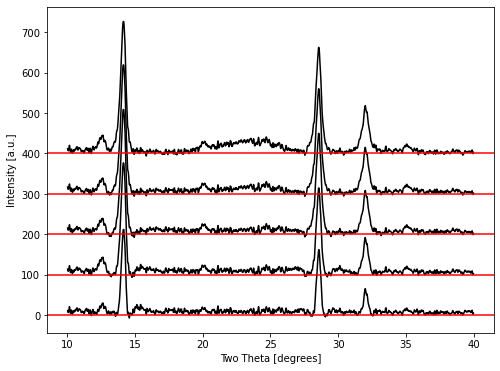

In [13]:
#   Import and process data

fig2, ax2 = plt.subplots(figsize=(8,6))
shift = 100

test = [10**4, 10**5,10**6,10**7,10**8]
test2 = [.00001, .0001, .001, .01, .1]
limit1 = 10
limit2 = 40
j = 0
for i in range(0,len(test)):
    def xrd_focus1(data,limit1,limit2):
        chem = pd.read_csv(data, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]

        chem_np = np.array(chem)
        back = baseline_als(chem_np[:,1], test[i], .01)
        chem_np[:,1] = savgol_filter((chem_np[:,1]-back),15,2)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        return chem_out

    sample0 = xrd_focus1(all_files[j],limit1,limit2)

    #   Plot curve and fit
    ax2.plot(sample0["2Theta"],sample0["Intensity"]+shift*i,'k-')
    ax2.axhline(shift*i, color='red')

    #ax2.plot(MAPbBr3["2Theta"],MAPbBr3["Intensity"]/10+shift*1,'b-')
    #ax2.plot(MAPbI3["2Theta"],MAPbI3["Intensity"]/10,'r-')
    ax2.set_xlabel('Two Theta [degrees]')
    ax2.set_ylabel('Intensity [a.u.]')

Cl                         0.6
I                         0.28
Br                        0.12
Predicted Lattice       5.8822
[100]                15.049494
[110]                21.345294
[200]                30.366709
[012]                34.054076
Amy                          F
Becky with [200]             T
Becky with [100]             T
Unnamed: 11                NaN
Name: 15, dtype: object


Text(0, 0.5, 'Intensity [a.u.]')

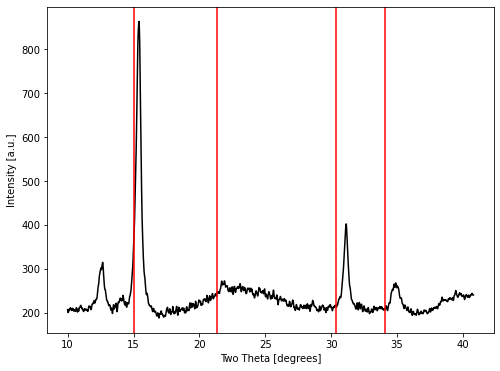

In [18]:
#   Import and process data

fig2, ax2 = plt.subplots(figsize=(8,6))
shift = 100

i = 15
sample0 = xrd_focus1(all_files[i],limit1,limit2)
print(chems.iloc[i])

#   Plot curve and fit
ax2.plot(sample0["2Theta"],sample0["Intensity"]+shift*2,'k-')
ax2.axvline(chems.iloc[i]['[100]'], color = "red")
ax2.axvline(chems.iloc[i]['[110]'], color = "red")
ax2.axvline(chems.iloc[i]['[200]'], color = "red")
ax2.axvline(chems.iloc[i]['[012]'], color = "red")

#ax2.plot(MAPbBr3["2Theta"],MAPbBr3["Intensity"]/10+shift*1,'b-')
#ax2.plot(MAPbI3["2Theta"],MAPbI3["Intensity"]/10,'r-')
ax2.set_xlabel('Two Theta [degrees]')
ax2.set_ylabel('Intensity [a.u.]')


# Survey of all compositions

Text(0, 0.5, 'Normalized Intensity [a.u.]')

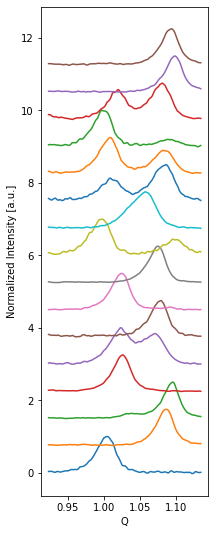

In [21]:
fig1, ax1 = plt.subplots(figsize=(3,9))

shift = .75
limit1 = 13
limit2 = 16

for i in range(0,len(all_files)):
    current = xrd_focus_q(all_files[i],limit1,limit2)
    ax1.plot(current["Q"],current["Intensity"]/np.max(current["Intensity"])+shift*i)

ax1.set_xlabel("Q")
ax1.set_ylabel('Normalized Intensity [a.u.]')
    

# Pull Lattice Constant [100]

0 Single Phase 0.12251731735660765 6.26529856423362


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1 Single Phase 0.10645524053284124 5.790177505283567


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2 Single Phase 0.1892351995592804 5.747025895006807


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3 Single Phase 0.10568486089487199 6.130976340569036
4 Double Phase 0.05911845449894472 6.139110606822886 5.871681013064729
5 Single Phase 0.16239161194597182 5.837076637751102
6 Single Phase 0.1278267006912671 6.142555031555681
7 Single Phase 0.14668095120274724 5.8537096912104385
8 Double Phase 0.11467995856770927 5.721403683666783 6.315139224588075
9 Single Phase 0.13736981663076892 5.9647261362225885
10 Double Phase 0.09731342608518279 5.8055191975297005 6.220181350715743
11 Double Phase 0.0984072721199451 6.243378817490482 5.8017369972216235
12 Double Phase 0.10958384391140402 5.761458532710201 6.2936840230483515
13 Double Phase 0.10749511024131783 5.822936358439018 6.16935342057406
14 Single Phase 0.10915812971904017 5.7258210486694505
15 Single Phase 0.11868214284028192 5.754880162240571


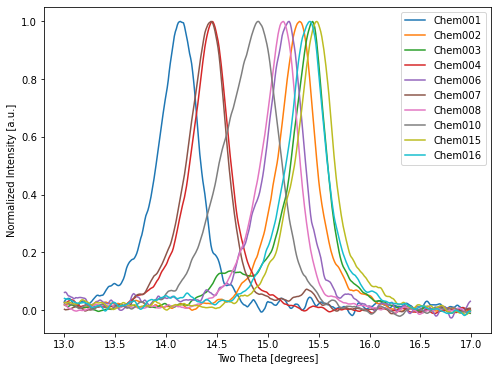

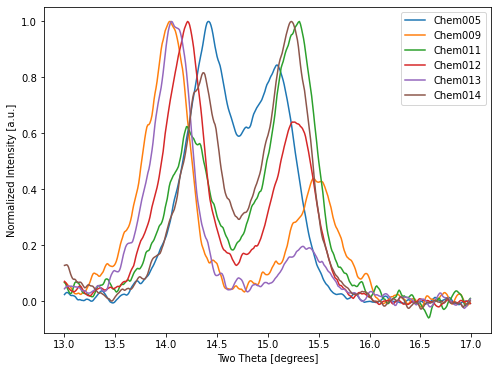

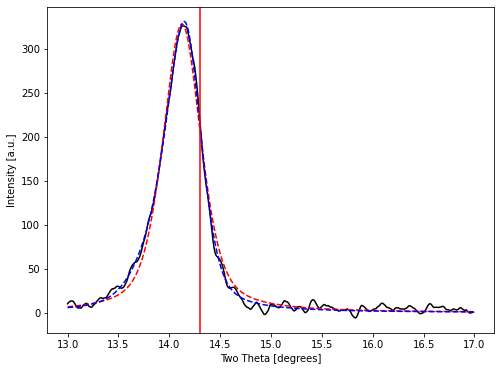

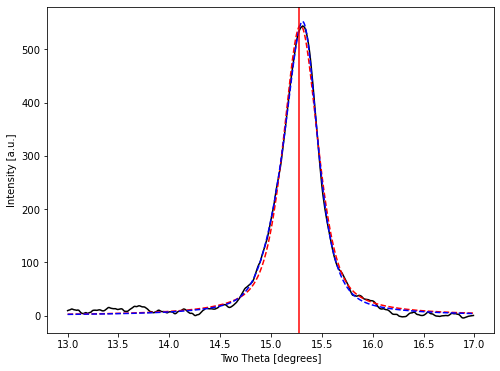

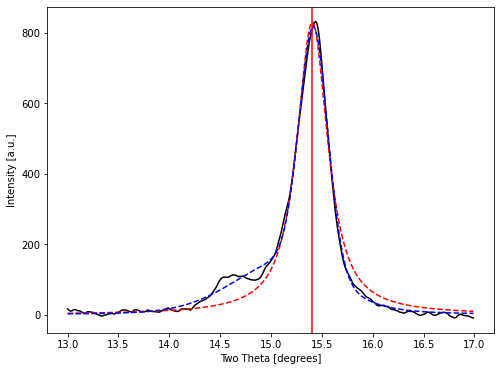

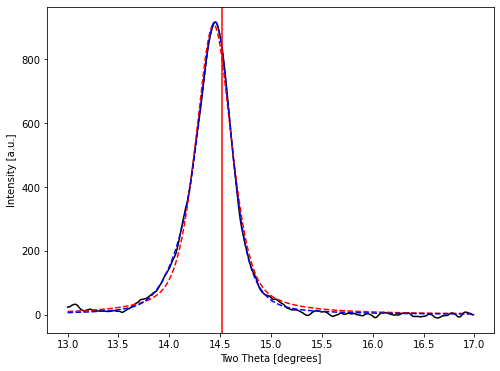

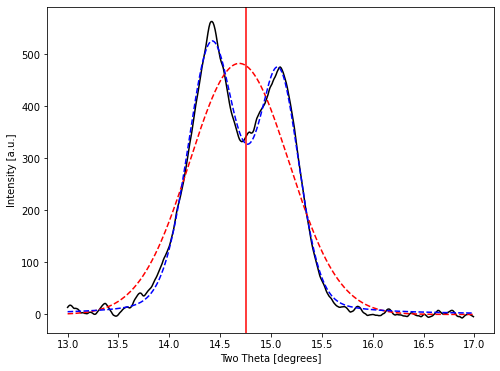

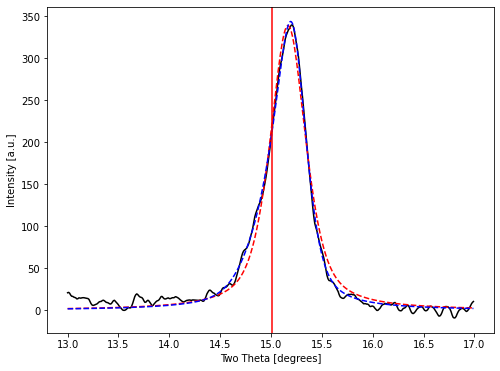

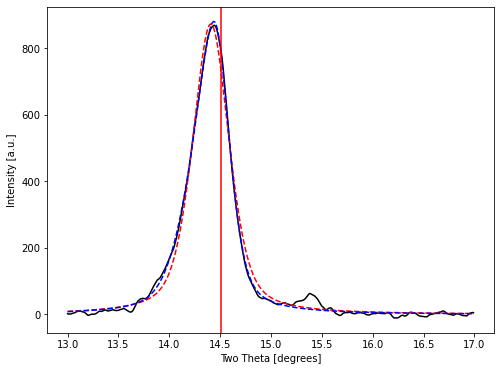

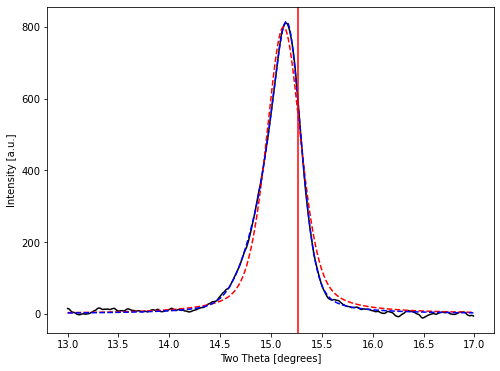

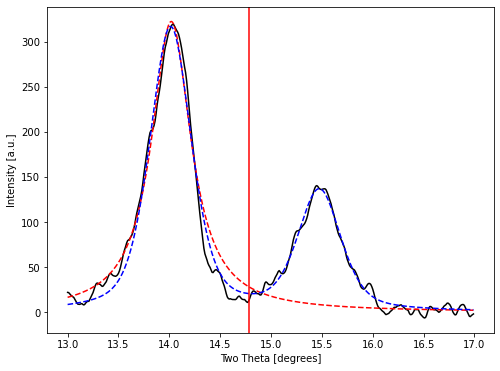

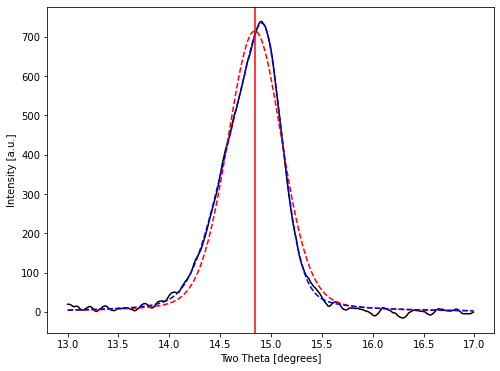

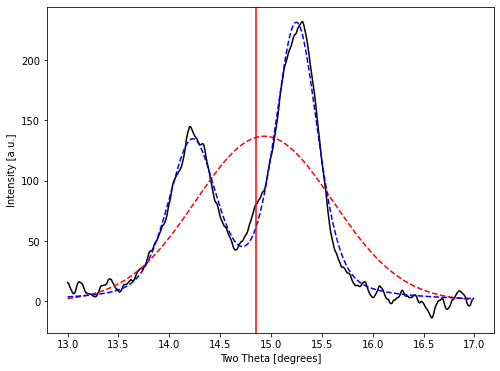

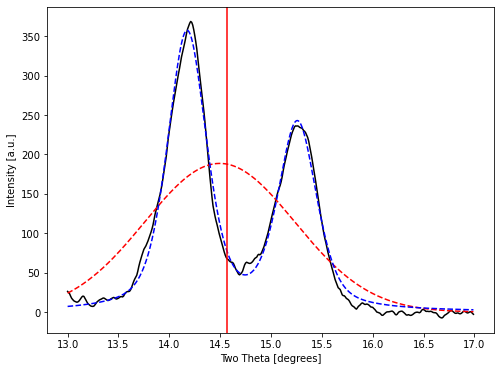

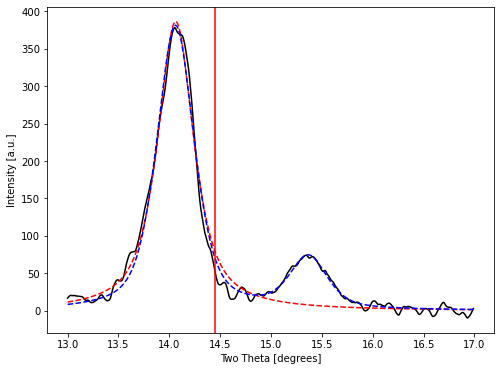

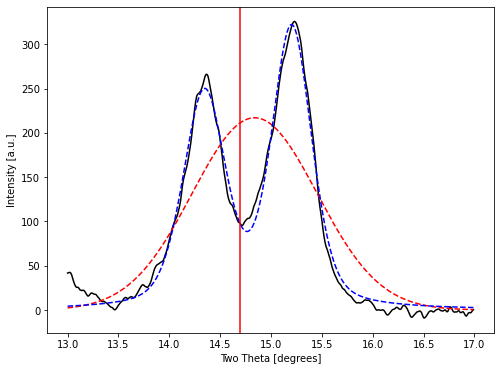

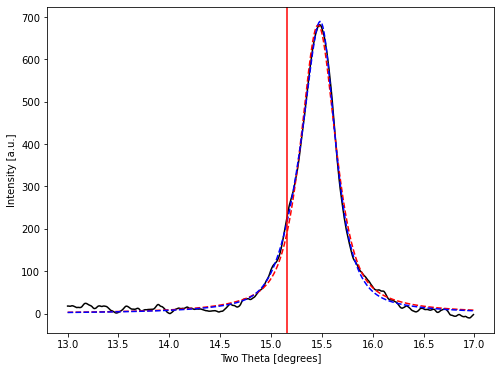

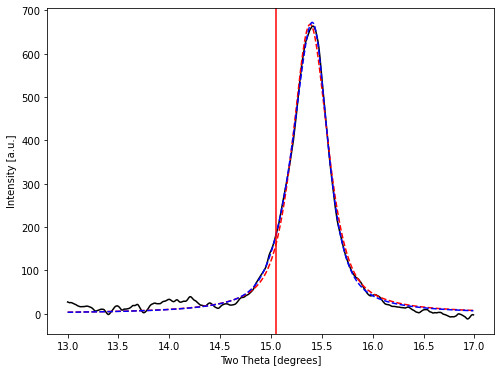

In [22]:
fig3, ax3 = plt.subplots(figsize=(8,6))
fig4, ax4 = plt.subplots(figsize=(8,6))
lattice1 = []
lattice2 = []

for i in range(0,len(all_files)):
    

    #   Set limits in two theta
    limit1 = 13
    limit2 = 17


    sample = xrd_focus1(all_files[i],limit1,limit2)
    #print(chems.iloc[i])

    #   Fit to a single pseudovoight
    chem_np = np.array(sample)
    #peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    peak = chems.iloc[i]['[100]']
    p0 = [0.2, np.max(chem_np[:,0]), peak, .1] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
    upper_limit = [1, 3000, limit2, 2]
    lower_limit = [0, 0, limit1, 0]
    popt, pcov = curve_fit(pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
    #print(popt)

    #   Fit to a double pseudovoight
    chem_np = np.array(sample)
    peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    p0 = [0.2, np.max(chem_np[:,0]), peak-.5, .1, np.max(chem_np[:,0]), peak+.5, .1,] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
    upper_limit = [1, 3000, limit2, 2, 3000, limit2, 2]
    lower_limit = [0, 0, limit1, 0,  0, limit1, 0]
    popt2, pcov2 = curve_fit(double_pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
    #print(popt2)


    if np.abs(popt2[2]-popt2[5])<0.5:
        residual = np.sum(np.abs(sample["Intensity"]-pvoigt(sample["2Theta"],*popt)))/np.sum(np.abs(sample["Intensity"]))
        print(i, 'Single Phase', residual, cubic_lattice(popt[2],[1,0,0]))
        ax3.plot(sample["2Theta"],sample["Intensity"]/np.max(sample["Intensity"]),label = 'Chem' + all_files[i].split('_')[-1].split('.')[0])
        lattice1.append(cubic_lattice(popt[2],[1,0,0]))
        lattice2.append(0)

    else:
        residual = np.sum(np.abs(sample["Intensity"]-double_pvoigt(sample["2Theta"],*popt2)))/np.sum(np.abs(sample["Intensity"]))
        print(i, 'Double Phase',residual, cubic_lattice(popt2[2],[1,0,0]),cubic_lattice(popt2[5],[1,0,0]))
        ax4.plot(sample["2Theta"],sample["Intensity"]/np.max(sample["Intensity"]),label = 'Chem' + all_files[i].split('_')[-1].split('.')[0])
        lattice1.append(cubic_lattice(popt2[2],[1,0,0]))
        lattice2.append(cubic_lattice(popt2[5],[1,0,0]))

    #   Plot curve and fit
    fig2, ax2 = plt.subplots(figsize=(8,6))
    ax2.plot(sample["2Theta"],sample["Intensity"],'k-')
    ax2.plot(sample["2Theta"],pvoigt(sample["2Theta"],*popt),'r--')
    ax2.plot(sample["2Theta"],double_pvoigt(sample["2Theta"],*popt2),'b--')
    ax2.axvline(chems.iloc[i]['[100]'], color = "red")
    ax2.set_xlabel('Two Theta [degrees]')
    ax2.set_ylabel('Intensity [a.u.]')

    ax3.legend()
    ax3.set_xlabel('Two Theta [degrees]')
    ax3.set_ylabel('Normalized Intensity [a.u.]')
    fig3.savefig("single.png")

    ax4.legend()
    ax4.set_xlabel('Two Theta [degrees]')
    ax4.set_ylabel('Normalized Intensity [a.u.]')
    fig4.savefig("double.png")



In [207]:
#   Build csv for data
lattice1 = np.array(lattice1)
lattice2 = np.array(lattice2)
chems_np = np.array(chems)


data = np.column_stack((chems_np,lattice1,lattice2))
data = pd.DataFrame(data)
data.columns = ["Cl","I","Br","Predicted Lattice", "[100]", "[110]","[200]","[012]",'Lattice 1', "Lattice 2"]
data.to_csv('Processed Results.csv')
print(data)

      Cl     I    Br  Predicted Lattice      [100]      [110]      [200]  \
0   0.10  0.79  0.11           6.189745  14.297732  20.273216  28.824330   
1   0.66  0.09  0.25           5.796186  15.274148  21.665855  30.828453   
2   0.83  0.07  0.10           5.749627  15.398579  21.843444  31.084371   
3   0.17  0.59  0.24           6.097984  14.514030  20.581580  29.267679   
4   0.32  0.42  0.26           5.999566  14.753436  20.922977  29.758790   
5   0.49  0.26  0.25           5.899074  15.006198  21.283524  30.277763   
6   0.00  0.50  0.50           6.102000  14.504428  20.567889  29.247989   
7   0.50  0.00  0.50           5.798500  15.268016  21.657103  30.815842   
8   0.50  0.50  0.00           5.988500  14.780850  20.962076  29.815054   
9   0.33  0.33  0.34           5.962490  14.845691  21.054559  29.948153   
10  0.45  0.40  0.15           5.961850  14.847293  21.056845  29.951443   
11  0.28  0.60  0.12           6.076440  14.565769  20.655353  29.373779   
12  0.24  0.

0 Single Phase 0.16167423632662709 6.247268326001803
1 Single Phase 0.35945594087682414 5.775974833884451
2 Double Phase 0.26439141319333953 5.730164197763994 6.05597993451277
3 Single Phase 0.11350199747963619 6.119323229941408
4 Double Phase 0.2350783203348352 5.853494603144269 6.131570098866652
5 Single Phase 0.369173446225824 5.822988283630588
6 Single Phase 0.1353780386235621 6.122614875578892
7 Single Phase 0.2728207951262214 5.8341759013078915
8 Single Phase 0.5767095174197265 6.288520596696027
9 Double Phase 0.28386469192779235 5.949824511976088 5.5029824378072405
10 Single Phase 0.6071336906076431 5.78324103015037
11 Double Phase 0.21659448923243238 6.226570832178709 5.773929930139246
12 Single Phase 0.3051820648832425 6.271196561983973
13 Double Phase 0.2713381432181816 6.1673530232443055 5.801812454837843
14 Double Phase 0.2942616641424461 5.714670513540006 5.845444447546818
15 Double Phase 0.286562536487303 5.745527256928312 5.918585244814064


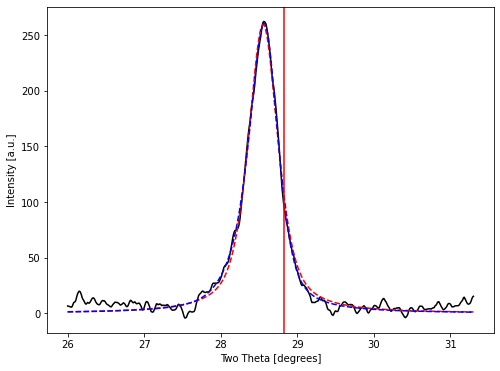

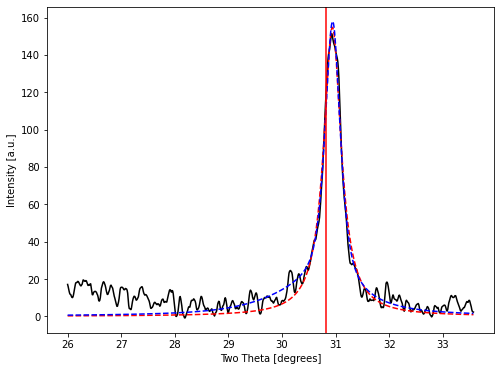

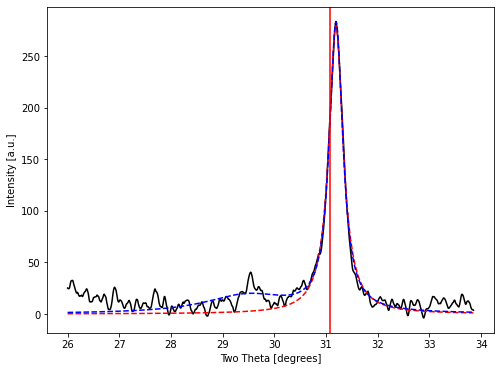

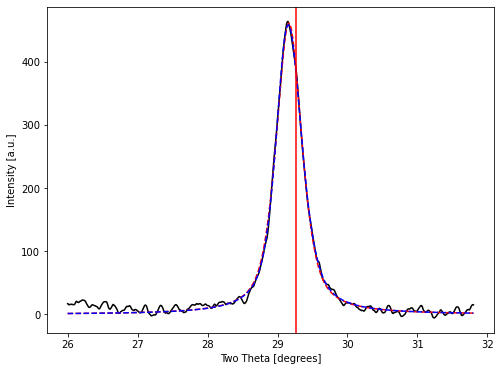

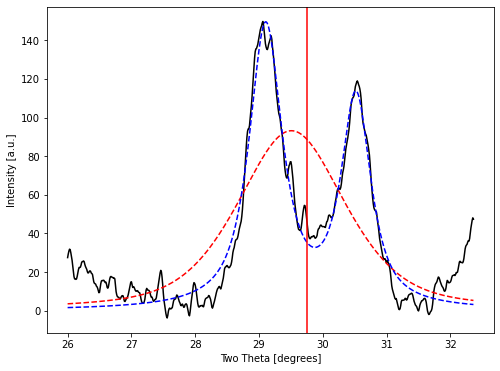

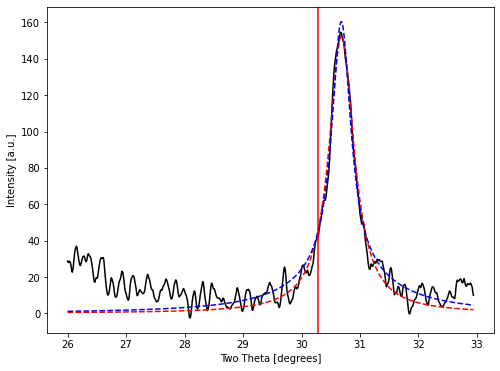

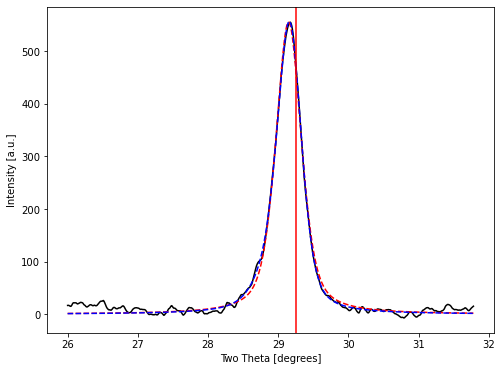

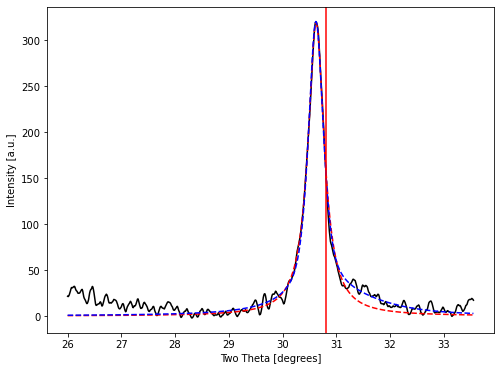

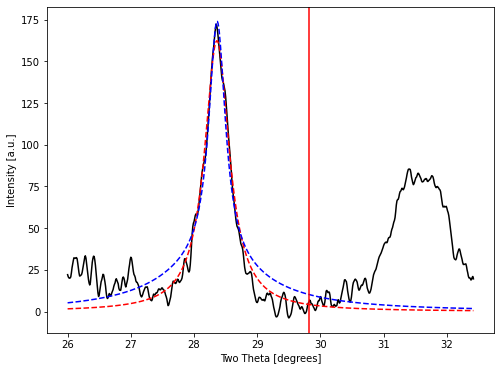

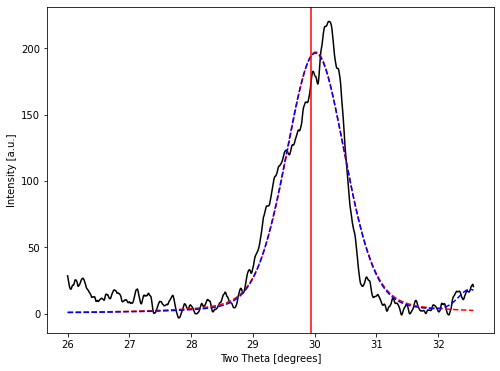

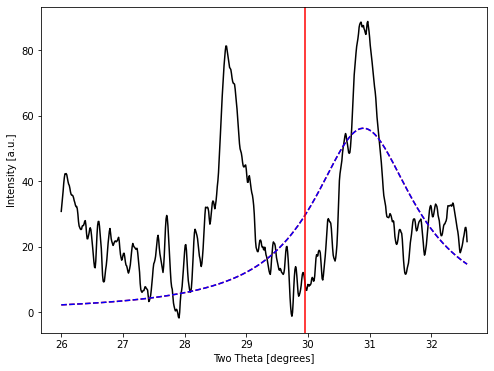

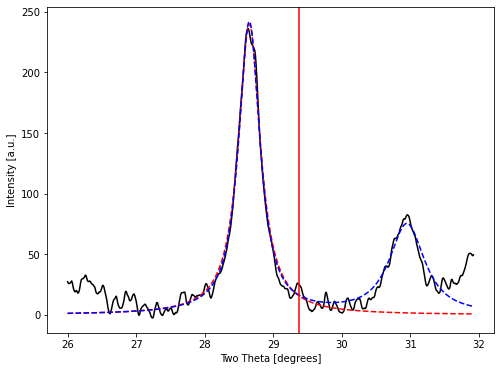

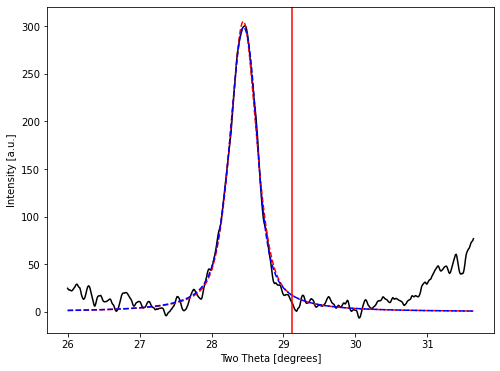

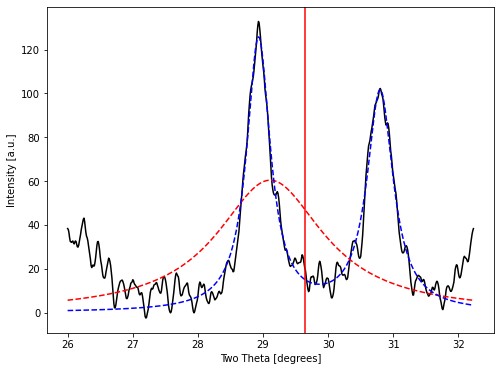

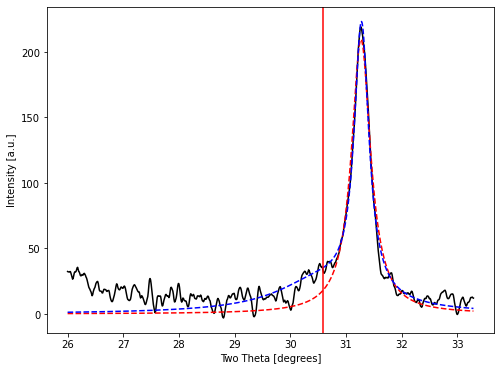

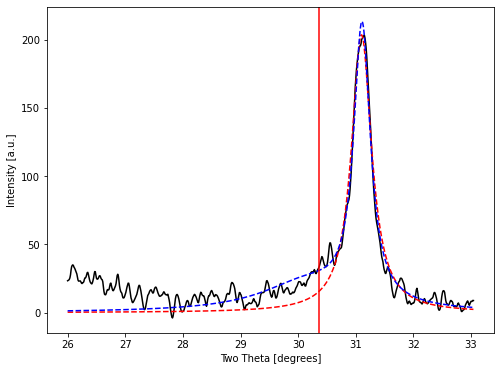

In [183]:

for i in range(0,len(all_files)):
    

    #   Set limits in two theta
    limit1 = 26
    limit2 = chems.iloc[i]['[012]']-1


    sample = xrd_focus1(all_files[i],limit1,limit2)
    #print(chems.iloc[i])

    #   Fit to a single pseudovoight
    chem_np = np.array(sample)
    #peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    peak = chems.iloc[i]['[200]']
    p0 = [0.2, np.max(chem_np[:,0]), peak, .1] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
    upper_limit = [1, 3000, limit2, 2]
    lower_limit = [0, 0, limit1, 0]
    popt, pcov = curve_fit(pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
    #print(popt)

    #   Fit to a double pseudovoight
    chem_np = np.array(sample)
    peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    p0 = [0.2, np.max(chem_np[:,0]), peak-1, .1, np.max(chem_np[:,0]), peak+1, .1,] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
    upper_limit = [1, 3000, limit2, 2, 3000, limit2, 2]
    lower_limit = [0, 0, limit1, 0,  0, limit1, 0]
    popt2, pcov2 = curve_fit(double_pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
    #print(popt2)


    if np.abs(popt2[2]-popt2[5])<0.5:
        residual = np.sum(np.abs(sample["Intensity"]-pvoigt(sample["2Theta"],*popt)))/np.sum(np.abs(sample["Intensity"]))
        print(i, 'Single Phase', residual, cubic_lattice(popt[2],[2,0,0]))
        
    else:
        residual = np.sum(np.abs(sample["Intensity"]-double_pvoigt(sample["2Theta"],*popt2)))/np.sum(np.abs(sample["Intensity"]))
        print(i, 'Double Phase',residual, cubic_lattice(popt2[2],[2,0,0]),cubic_lattice(popt2[5],[2,0,0]))

   
    fig2, ax2 = plt.subplots(figsize=(8,6))
    ax2.plot(sample["2Theta"],sample["Intensity"],'k-')
    ax2.plot(sample["2Theta"],pvoigt(sample["2Theta"],*popt),'r--')
    ax2.plot(sample["2Theta"],double_pvoigt(sample["2Theta"],*popt2),'b--')
    ax2.axvline(chems.iloc[i]['[200]'], color = "red")
    ax2.set_xlabel('Two Theta [degrees]')
    ax2.set_ylabel('Intensity [a.u.]')

#   PL Results

In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

def trim_data(x,data,limit1,limit2):
    set1 = find_nearest(x,limit1)
    set2 = find_nearest(x,limit2)
    return x[set1:set2], data[set1:set2]

def weighted_PL(wave,intensity):
    return np.sum(wave*intensity)/np.sum(intensity)

def back_subtract(x,data,length):
    x_linear = np.hstack((x[0:length],x[-length:-1]))
    data_linear = np.hstack((data[0:length],data[-length:-1]))
    slope, intercept = np.polyfit(x_linear, data_linear,1)
    back = slope*x+intercept
    data_correct = data-back
    return data_correct

In [ ]:
# set up details of experiment 
path = r'/Users/rbelisle/Desktop/FAPbX3 Data/FAPbI04Cl005_anneal/160C/PL' # use your path
all_files = sorted(glob.glob(path + "/*.csv"))
lim1 = 550 #high energy cutoff
lim2 = 900 #low energy cutoff
sample = ['no quench', '0 min', '1 min', '5 min', '15 min', '30 min', '120 min']
print(all_files)
df = pd.read_csv(all_files[6], header = 0)
df.columns = ["Frame","Wavelength","Intensity", "Exposure started time stamp", "Exposure ended time stamp"]

#Process data
cofm_PL = []
time = []
fig1,ax1 = plt.subplots()
init_time = np.min(df['Exposure started time stamp'])

first = df[df['Frame'] == 12]['Intensity'] #read file
last = df[df['Frame'] == np.max(df['Frame'])]['Intensity']
wave = df[df['Frame'] == 13]['Wavelength'] #read file



plt.plot(wave, first)
first_frames = [12,  12, 11, 12, 12,12,12]


In [ ]:

#open file
for i in range(0, len(all_files)):
    df = pd.read_csv(all_files[i], header = 0)
    df.columns = ["Frame","Wavelength","Intensity", "Exposure started time stamp", "Exposure ended time stamp"]
    
    #Process data
    cofm_PL = []
    time = []
    fig1,ax1 = plt.subplots()

    first = np.array(df[df['Frame'] == first_frames[i]]['Intensity']) - np.array(df[df['Frame'] == 2]["Intensity"])  #read file
    last = np.array(df[df['Frame'] == np.max(df['Frame'])]['Intensity']) - np.array(df[df['Frame'] == 2]["Intensity"])
    init_time = np.array(df[df['Frame'] == first_frames[i]]['Exposure started time stamp'])[0]

    # for x in df['Frame'].unique():
    for x in range(first_frames[i],np.max(df['Frame'])):
        current = df[df['Frame'] == x] #read specific frame
        wave = current['Wavelength']
        intensity = current['Intensity'] 
        wave_cut, PL_cut = trim_data(wave,intensity,lim1,lim2)
        wave_back, back =  trim_data(df[df['Frame'] == 1]["Wavelength"],df[df['Frame'] == 1]["Intensity"],lim1,lim2)
        PL_back = np.array(PL_cut)-np.array(back)
        ax1.plot(wave_cut,PL_back)
        cofm_PL.append(weighted_PL(wave_cut,PL_back))
        time.append((np.array(current['Exposure ended time stamp'])[0]+np.array(current['Exposure started time stamp'])[0])/2)
    ax1.set_xlabel("Wavelength [nm]")
    ax1.set_ylabel("Intensity [nm]")
    
    #fig1.savefig(path+"/"+chem+".png")

    true_time = (time-init_time)/(10**6)
    fig2,ax2 = plt.subplots()
    ax2.plot(true_time, cofm_PL, 'k--')
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Center of Mass Wavelength [nm]")
    #fig2.savefig(path+"/"+chem+".png")
    print(all_files[i])
    fig3,ax3 = plt.subplots()
    ax3.plot(wave, first/np.max(first), 'b-', label = "first frame")
    ax3.plot(wave,last/np.max(last), 'r-', label = "last frame")
    ax3.set_xlabel("Wavelength [nm]")
    ax3.set_ylabel("Intensity [nm]")
    ax3.set_xlim([lim1,lim2])
    ax3.legend(loc="upper right")

    plt.show()
    plt.close('all')

# %%

#   Initial (Norm), Final (Norm), and Compare

In [ ]:
fig1,ax1 = plt.subplots()
ax1.set_xlabel("Wavelength [nm]")
ax1.set_ylabel("Intensity [a.u.]")
ax1.set_xlim([550,850])


fig2,ax2 = plt.subplots()
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Center of Mass Wavelength [nm]")


fig3,ax3 = plt.subplots()
ax3.set_xlabel("Wavelength [nm]")
ax3.set_ylabel("Intensity [a.u.]")

colors = ['grey', 'black', 'red', 'blue', 'green', 'magenta', 'darkturquoise']


for i in range(0, len(all_files)):
    df = pd.read_csv(all_files[i], header = 0)
    df.columns = ["Frame","Wavelength","Intensity", "Exposure started time stamp", "Exposure ended time stamp"]
    
    #Process data
    cofm_PL = []
    time = []

    #Plot first
    first = df[df['Frame'] == first_frames[i]] #read specific frame
    wave = first['Wavelength']
    intensity = np.array(first['Intensity']) - np.array(df[df['Frame'] == 2]["Intensity"])    
    wave = first['Wavelength']

    wave_cut, PL_cut = trim_data(wave,intensity,550,850)
    wave_back, back =  trim_data(df[df['Frame'] == 1]["Wavelength"],df[df['Frame'] == 1]["Intensity"],550,850)
    PL_back = np.array(PL_cut)-np.array(back)
    ax1.plot(wave_cut,PL_back/np.max(PL_back), color = colors[i], label = sample[i])

    init_time = np.array(df[df['Frame'] == first_frames[i]]['Exposure started time stamp'])[0]
     
    
    #Plot last
    last = df[df['Frame'] == np.max(df['Frame'])] #read specific frame
    wave = last['Wavelength']
    intensity = np.array(last['Intensity']) - np.array(df[df['Frame'] == 2]["Intensity"]) 
    wave_cut, PL_cut = trim_data(wave,intensity,lim1,lim2)
    wave_back, back =  trim_data(df[df['Frame'] == 1]["Wavelength"],df[df['Frame'] == 1]["Intensity"],lim1,lim2)
    PL_back = np.array(PL_cut)-np.array(back)
    ax3.plot(wave_cut,PL_back/np.max(PL_back), color = colors[i],label = sample[i])

    # for x in df['Frame'].unique():
    for x in range(first_frames[i],np.max(df['Frame'])):
        current = df[df['Frame'] == x] #read specific frame
        wave = current['Wavelength']
        intensity = current['Intensity'] 
        wave_cut, PL_cut = trim_data(wave,intensity,lim1,lim2)
        wave_back, back =  trim_data(df[df['Frame'] == 1]["Wavelength"],df[df['Frame'] == 1]["Intensity"],lim1,lim2)
        PL_back = np.array(PL_cut)-np.array(back)
        cofm_PL.append(weighted_PL(wave_cut,PL_back))
        time.append((np.array(current['Exposure ended time stamp'])[0]+np.array(current['Exposure started time stamp'])[0])/2)
    
    
    #fig1.savefig(path+"/"+chem+".png")

    true_time = (time-init_time)/(10**6)
    ax2.plot(true_time, cofm_PL, color = colors[i],label = sample[i])

ax1.legend(loc="upper right")
ax2.legend(loc="lower right")
ax3.legend(loc="upper right")

fig2.savefig("FAPbI04Cl005_anneal_PL.png", dpi = 300)

plt.show()
    

In [ ]:
fig1,ax1 = plt.subplots()
ax1.set_xlabel("Wavelength [nm]")
ax1.set_ylabel("Intensity [nm]")


fig2,ax2 = plt.subplots()
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Center of Mass Wavelength [nm]")


fig3,ax3 = plt.subplots()
ax3.set_xlabel("Wavelength [nm]")
ax3.set_ylabel("Intensity [nm]")



for i in range(0, len(all_files)):
    df = pd.read_csv(all_files[i], header = 0)
    df.columns = ["Frame","Wavelength","Intensity", "Exposure started time stamp", "Exposure ended time stamp"]
    
    #Process data
    cofm_PL = []
    time = []

    #Plot first
    first = df[df['Frame'] == first_frames[i]] #read specific frame
    wave = first['Wavelength']
    intensity = first['Intensity'] 
    wave_cut, PL_cut = trim_data(wave,intensity,lim1,lim2)
    wave_back, back =  trim_data(df[df['Frame'] == 1]["Wavelength"],df[df['Frame'] == 1]["Intensity"],lim1,lim2)
    PL_back = np.array(PL_cut)-np.array(back)
    ax1.plot(wave_cut,PL_back, label = sample[i])

    init_time = np.array(df[df['Frame'] == first_frames[i]]['Exposure started time stamp'])[0]
     
    
    #Plot last
    last = df[df['Frame'] == np.max(df['Frame'])] #read specific frame
    wave = last['Wavelength']
    intensity = last['Intensity'] 
    wave_cut, PL_cut = trim_data(wave,intensity,lim1,lim2)
    wave_back, back =  trim_data(df[df['Frame'] == 1]["Wavelength"],df[df['Frame'] == 1]["Intensity"],lim1,lim2)
    PL_back = np.array(PL_cut)-np.array(back)
    ax3.plot(wave_cut,PL_back, label = sample[i])

    # for x in df['Frame'].unique():
    for x in range(first_frames[i],np.max(df['Frame'])):
        current = df[df['Frame'] == x] #read specific frame
        wave = current['Wavelength']
        intensity = current['Intensity'] 
        wave_cut, PL_cut = trim_data(wave,intensity,lim1,lim2)
        wave_back, back =  trim_data(df[df['Frame'] == 1]["Wavelength"],df[df['Frame'] == 1]["Intensity"],lim1,lim2)
        PL_back = np.array(PL_cut)-np.array(back)
        cofm_PL.append(weighted_PL(wave_cut,PL_back))
        time.append((np.array(current['Exposure ended time stamp'])[0]+np.array(current['Exposure started time stamp'])[0])/2)
    
    
    #fig1.savefig(path+"/"+chem+".png")

    true_time = (time-init_time)/(10**6)
    ax2.plot(true_time, cofm_PL, label = sample[i])

ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax3.legend(loc="upper right")


plt.show()
    